## Import python modules

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from threading import Thread

import os
import sys
import glob
import random
print("Imported!")

Imported!


## Set Hyperparameters

In [2]:
granularity = 128
total_size = (629_145_480 + granularity - 1) // granularity
seg_size = (150_000 + granularity - 1) // granularity
bin_size = (2**12 + granularity - 1) // granularity # data comes in bins of 2^12 contiguous rows (ADC with 12-bit resolution)
bins_per_seg = (seg_size + bin_size - 1) // bin_size # ceil(seg_size / bin_size)
case_size = bins_per_seg * bin_size
target_size = 10

epochs = 1 * bins_per_seg # there are bins_per_seg number of shifts
batch_size = 2**5
feature_size = 5
valid_steps = 4
learning_rate = 0.0005

total_cases = total_size // case_size
total_batches = (total_cases + batch_size - 1) // batch_size

withheld_cases = 2**8
withheld_batches = (withheld_cases + batch_size - 1) // batch_size
withheld_size = withheld_cases * case_size
withheld_percent = 100 * withheld_size / total_size

valid_cases = valid_steps * batch_size
valid_batches = (valid_cases + batch_size - 1) // batch_size
valid_size = valid_cases * case_size
valid_percent = 100 * valid_size / total_size

train_size = total_size - valid_size - withheld_size
train_cases = total_cases - valid_cases - withheld_cases
train_batches = (train_cases + batch_size - 1) // batch_size
train_percent = 100 * train_size / total_size


print("----- Hyperparameters -----")
print("epochs:", epochs)
print("batch_size:", batch_size)
print("feature_size:", feature_size)
print("valid_steps:", valid_steps)
print("learning_rate:", learning_rate)
print("---------------------------")
print("seg_size:", seg_size)
print("bin_size:", bin_size)
print("bins_per_seg:", bins_per_seg)
print("case_size:", case_size)
print("target_size:", target_size)
print("granularity:", granularity)
print("total_cases:", total_cases)
print("total_batches:", total_batches)
print("withheld_cases:", withheld_cases)
print("withheld_batches:", withheld_batches)
print("valid_cases:", valid_cases)
print("valid_batches:", valid_batches)
print("train_cases:", train_cases)
print("train_batches:", train_batches)
print("---------------------------")
print("total_size:       {0:9d}".format(total_size))
print("withheld_size:    {0:9d}".format(withheld_size))
print("train_size:       {0:9d}".format(train_size))
print("valid_size:       {0:9d}".format(valid_size))
print("---------------------------")
print("withheld_percent: {0:8.2f}%".format(withheld_percent))
print("valid_percent:    {0:8.2f}%".format(valid_percent))
print("train_percent:    {0:8.2f}%".format(train_percent))
print("---------------------------")

----- Hyperparameters -----
epochs: 37
batch_size: 32
feature_size: 5
valid_steps: 4
learning_rate: 0.0005
---------------------------
seg_size: 1172
bin_size: 32
bins_per_seg: 37
case_size: 1184
target_size: 10
granularity: 128
total_cases: 4151
total_batches: 130
withheld_cases: 256
withheld_batches: 8
valid_cases: 128
valid_batches: 4
train_cases: 3767
train_batches: 118
---------------------------
total_size:         4915200
withheld_size:       303104
train_size:         4460544
valid_size:          151552
---------------------------
withheld_percent:     6.17%
valid_percent:        3.08%
train_percent:       90.75%
---------------------------


## Preprocessing

In [3]:
# A vector with 1's marking the end of a bin
bin_end = np.zeros((1, bin_size), dtype=np.float32)
bin_end[0,-1] = 1.0

def create_features(df):
    fullmean = (df['acoustic_data'].mean() - 4.47) / 1.5
    fullstd = (df['acoustic_data'].std() - 4.26) / 9.7
    fullmax = (df['acoustic_data'].max() - 13.83) / 19.0
    fullmin = (df['acoustic_data'].min() + 4.83) / 18.6
    binend = 0.0 if df.index[0] % bin_size == bin_size-1 else 1.0
    return np.c_[fullmean, fullstd, fullmax, fullmin, binend]

def create_targets(df):
    return df.tail(1).time_to_failure.values[0]

data = pd.read_csv('../input/train.csv', chunksize=granularity, dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})

features = []
targets = []

for df in tqdm(data, total=total_size):
    features.append(create_features(df))
    targets.append(create_targets(df))
    
features = np.asarray(features[:-withheld_size])
targets = np.asarray(targets[:-withheld_size])
withheld_features = np.asarray(features[withheld_size:])
withheld_targets = np.asarray(targets[withheld_size:])

print("Done reading data!")
numpy.savetxt("../input/features-{0}.csv".format(granularity), features, delimiter=",")
numpy.savetxt("../input/targets-{0}.csv".format(granularity), targets, delimiter=",")
numpy.savetxt("../input/withheld-features-{0}.csv".format(granularity), withheld_features, delimiter=",")
numpy.savetxt("../input/withheld-targets-{0}.csv".format(granularity), withheld_targets, delimiter=",")
print("Done saving data!")

 22%|██▏       | 1078459/4915200 [1:16:47<11:03:57, 96.31it/s] 

KeyboardInterrupt: 

## Data Augmentation

In [69]:
def batch_gen(validation=False):
    batch_samples = np.zeros((batch_size, seg_size, feature_size))
    batch_targets = np.zeros((batch_size, 1))
    while True:
        for shift in random.sample(range(bins_per_seg), bins_per_seg):
            batches = valid_batches if validation else train_batches
            cases = valid_cases if validation else train_cases
            case_idxs = random.sample(range(cases), cases)
            for batch in range(batches):
                start_case = batch * batch_size
                end_case = start_case + batch_size

                for i, case in enumerate(case_idxs[start_case:end_case]):
                    start_row = case * case_size + shift * bin_size
                    end_row = start_row + seg_size
                    batch_samples[i, j] = features[start_row:end_row]
                    batch_targets[i] = targets[start_row:end_row]
                yield samples, targets

train = batch_gen()
valid = batch_gen(validation=True)

## Data visualization

## Define Model

In [70]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, 

cb = [ModelCheckpoint("dcnn-2-model.hdf5", monitor='val_loss', save_weights_only=False, period=3)]
if True:
    cb += [TensorBoard(log_dir="logs/{}".format(time()))]

model = Sequential()
model.add(Conv1D(32, 2, activation='relu', dilation_rate=2**0, strides=1, input_shape=(seq_size, feature_size)))
model.add(Conv1D(32, 2, activation='relu', dilation_rate=2**1, strides=1, input_shape=(None, 32))) 
model.add(Conv1D(32, 2, activation='relu', dilation_rate=2**0, strides=1, input_shape=(None, 32))) 
model.add(Conv1D(64, 2, activation='relu', dilation_rate=2**1, strides=1, input_shape=(None, 32)))   
model.add(Conv1D(64, 2, activation='relu', dilation_rate=2**2, strides=1, input_shape=(None, 64))) 
model.add(Conv1D(128, 2, activation='relu', dilation_rate=2**3, strides=1, input_shape=(None, 64))) 
model.add(Conv1D(128, 2, activation='relu', dilation_rate=2**4, strides=1, input_shape=(None, 128))) 
model.add(Conv1D(256, 2, activation='relu', dilation_rate=2**5, strides=1, input_shape=(None, 128))) 
model.add(Conv1D(256, 2, activation='relu', dilation_rate=2**6, strides=1, input_shape=(None, 256)))
model.add(Conv1D(256, 3, activation='relu', dilation_rate=2**7, strides=1, input_shape=(None, 256))) 
model.add(Conv1D(256, 3, activation='relu', dilation_rate=2**7*3, strides=1, input_shape=(None, 256)))   
# model.add(MaxPooling1D(44, strides=16, padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.summary()

# Compile and fit model
model.compile(optimizer=adam(lr=learning_rate), loss="mae", metrics="")

history = model.fit_generator(train,
                              steps_per_epoch=train_batches,
                              epochs=epochs,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid,
                              validation_steps=valid_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_435 (Conv1D)          (None, 1170, 32)          352       
_________________________________________________________________
conv1d_436 (Conv1D)          (None, 1168, 32)          2080      
_________________________________________________________________
conv1d_437 (Conv1D)          (None, 1167, 32)          2080      
_________________________________________________________________
conv1d_438 (Conv1D)          (None, 1165, 64)          4160      
_________________________________________________________________
conv1d_439 (Conv1D)          (None, 1161, 64)          8256      
_________________________________________________________________
conv1d_440 (Conv1D)          (None, 1153, 128)         16512     
_________________________________________________________________
conv1d_441 (Conv1D)          (None, 1137, 128)         32896     
__________

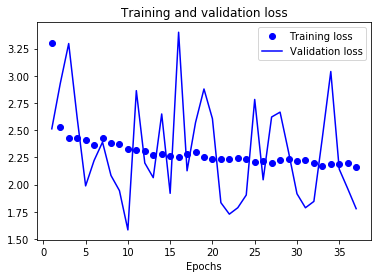

In [72]:
%matplotlib inline
# Visualize accuracies
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1

    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [77]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(submission.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv', dtype={'acoustic_data': np.float32})
    samples = np.zeros((seq_size, feature_size))
    for j, gran in seg.groupby(seg.index % case_size % bin_size // granularity):
        samples[j] = create_features(gran)
    predict = model.predict(np.expand_dims(samples, 0))
    print('\r', i, seg_id, submission.shape[0], predict, end = '')
    submission.time_to_failure[i] = predict

submission.head()

# Save
submission.to_csv('submission.csv')


 2623 seg_ffe7cc 2624 [[12.821518]]]624 [[10.101119]]2624 [[19.719547]][[4.358842]] seg_8fb828 2624 [[13.608048]]seg_a25c46 2624 [[3.311316]] [[5.0048532]][[5.6201353]]